In [1]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

In [2]:
# Set the directory paths
phone_accel_path = r'C:\Users\25805576\OneDrive - Edge Hill University\.ipynb_checkpoints\accel_phone'
phone_gyro_path = r'C:\Users\25805576\OneDrive - Edge Hill University\.ipynb_checkpoints\accel_watch'
watch_accel_path = r'C:\Users\25805576\OneDrive - Edge Hill University\.ipynb_checkpoints\gyro_phone'
watch_gyro_path = r'C:\Users\25805576\OneDrive - Edge Hill University\.ipynb_checkpoints\gyro_watch'

# Helper function to extract the numeric part from the filename
def extract_number(filename):
    match = re.search(r'data\_(\d+)\_', filename)
    return int(match.group(1)) if match else 0

# Function to process files in a directory and load data into a DataFrame
def process_files_to_dataframe(directory):
    filenames = os.listdir(directory)
    filenames.sort(key=extract_number)  # Sort filenames numerically
    
    data = []
    for filename in filenames:
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.strip().split(',')
                    if len(values) == 6:
                        subject_id = int(values[0])
                        activity_code = values[1]
                        timestamp = int(values[2])
                        x = float(values[3])
                        y = float(values[4])
                        z = float(values[5].rstrip(';'))
                        data.append([subject_id, activity_code, timestamp, x, y, z])
    
    columns = ['subject_id', 'activity_code', 'timestamp', 'x', 'y', 'z']
    df = pd.DataFrame(data, columns=columns)
    return df

# Load data from each directory into DataFrames
phone_accel_df = process_files_to_dataframe(phone_accel_path)
phone_gyro_df = process_files_to_dataframe(phone_gyro_path)
watch_accel_df = process_files_to_dataframe(watch_accel_path)
watch_gyro_df = process_files_to_dataframe(watch_gyro_path)

In [17]:
# Display the Phone Accelerometer Data
print("Phone Accelerometer Data:")
print(phone_accel_df.head())

# Display the Phone Gyroscope Data
print("\nPhone Gyroscope Data:")
print(phone_gyro_df.head())

# Display the Watch Accelerometer Data
print("\nWatch Accelerometer Data:")
print(watch_accel_df.head())

# Display the Watch Gyroscope Data
print("\nWatch Gyroscope Data:")
print(watch_gyro_df.head())


Phone Accelerometer Data:
   subject_id activity_code                  timestamp         x          y  \
0        1600       Walking 1977-12-29 01:41:06.810782 -0.364761   8.793503   
1        1600       Walking 1977-12-29 01:41:57.164786 -0.879730   9.768784   
2        1600       Walking 1977-12-29 01:42:47.518790  2.001495  11.109070   
3        1600       Walking 1977-12-29 01:43:37.872794  0.450623  12.651642   
4        1600       Walking 1977-12-29 01:44:28.226798 -2.164352  13.928436   

          z  accel_mag  
0  1.055084   8.864082  
1  1.016998   9.860900  
2  2.619156  11.587812  
3  0.184555  12.661010  
4 -4.422485  14.773088  

Phone Gyroscope Data:
   subject_id activity_code                  timestamp         x         y  \
0        1600       Walking 1972-11-12 14:31:48.196641  7.091625 -0.591667   
1        1600       Walking 1972-11-12 14:32:37.696641  4.972757 -0.158317   
2        1600       Walking 1972-11-12 14:33:27.196641  3.253720 -0.191835   
3        1600 

In [4]:
# # Exploratory Data Analysis (EDA)

# In[11]:


# Define the activity code to label mapping
activity_labels = {
    'A': 'Walking',
    'B': 'Jogging',
    'C': 'Stairs - Up',
    'D': 'Stairs - Down',
    'E': 'Sitting',
    'F': 'Standing',
    'G': 'Typing',
    'H': 'Brushing Teeth',
    'I': 'Eating Soup',
    'J': 'Eating Chips',
    'K': 'Eating Pasta',
    'L': 'Drinking from Cup',
    'M': 'Eating Sandwich',
    'O': 'Kicking',
    'P': 'Playing Catch',
    'Q': 'Dribbling',
    'R': 'Writing',
    'S': 'Clapping'
}

# Replace activity codes with labels in the DataFrame
phone_accel_df['activity_code'] = phone_accel_df['activity_code'].map(activity_labels)
phone_gyro_df['activity_code'] = phone_gyro_df['activity_code'].map(activity_labels)
watch_accel_df['activity_code'] = watch_accel_df['activity_code'].map(activity_labels)
watch_gyro_df['activity_code'] = watch_gyro_df['activity_code'].map(activity_labels)

# Print the updated DataFrames
print("\nPhone Accelerometer DataFrame:")
print(phone_accel_df.head())
print("\nPhone Gyroscope DataFrame:")
print(phone_gyro_df.tail())
print("\nWatch Accelerometer DataFrame:")
print(watch_accel_df.tail())
print("\nWatch Gyroscope DataFrame:")
print(watch_gyro_df.head())


Phone Accelerometer DataFrame:
   subject_id activity_code        timestamp         x          y         z
0        1600       Walking  252207666810782 -0.364761   8.793503  1.055084
1        1600       Walking  252207717164786 -0.879730   9.768784  1.016998
2        1600       Walking  252207767518790  2.001495  11.109070  2.619156
3        1600       Walking  252207817872794  0.450623  12.651642  0.184555
4        1600       Walking  252207868226798 -2.164352  13.928436 -4.422485

Phone Gyroscope DataFrame:
         subject_id activity_code         timestamp         x          y  \
3777041        1650      Clapping  2426184421424592  1.486500 -13.302334   
3777042        1650      Clapping  2426184471411932  4.017171 -13.146711   
3777043        1650      Clapping  2426184521399272  4.412214 -15.318253   
3777044        1650      Clapping  2426184571385262  4.426579 -13.012636   
3777045        1650      Clapping  2426184621371252  3.765780 -11.798776   

                z  
3777041

In [5]:
# Check for missing values in each DataFrame
phone_accel_missing = phone_accel_df.isnull().sum()
phone_gyro_missing = phone_gyro_df.isnull().sum()
watch_accel_missing = watch_accel_df.isnull().sum()
watch_gyro_missing = watch_gyro_df.isnull().sum()

# Display the missing value counts for each DataFrame
print("Missing values in phone_accel_df:")
print(phone_accel_missing)
print("\nMissing values in phone_gyro_df:")
print(phone_gyro_missing)
print("\nMissing values in watch_accel_df:")
print(watch_accel_missing)
print("\nMissing values in watch_gyro_df:")
print(watch_gyro_missing)

Missing values in phone_accel_df:
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
dtype: int64

Missing values in phone_gyro_df:
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
dtype: int64

Missing values in watch_accel_df:
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
dtype: int64

Missing values in watch_gyro_df:
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
dtype: int64


In [6]:
# Display information about each DataFrame
print("Information about phone_accel_df:")
phone_accel_df.info()

print("\nInformation about phone_gyro_df:")
phone_gyro_df.info()

print("\nInformation about watch_accel_df:")
watch_accel_df.info()

print("\nInformation about watch_gyro_df:")
watch_gyro_df.info()

Information about phone_accel_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804403 entries, 0 to 4804402
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   subject_id     int64  
 1   activity_code  object 
 2   timestamp      int64  
 3   x              float64
 4   y              float64
 5   z              float64
dtypes: float64(3), int64(2), object(1)
memory usage: 219.9+ MB

Information about phone_gyro_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777046 entries, 0 to 3777045
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   subject_id     int64  
 1   activity_code  object 
 2   timestamp      int64  
 3   x              float64
 4   y              float64
 5   z              float64
dtypes: float64(3), int64(2), object(1)
memory usage: 172.9+ MB

Information about watch_accel_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608635 entries, 0 to 3608634
Data columns (tot

In [7]:
# Convert 'timestamp' column to datetime type
phone_accel_df['timestamp'] = pd.to_datetime(phone_accel_df['timestamp'], unit='us')
phone_gyro_df['timestamp'] = pd.to_datetime(phone_gyro_df['timestamp'], unit='us')
watch_accel_df['timestamp'] = pd.to_datetime(watch_accel_df['timestamp'], unit='us')
watch_gyro_df['timestamp'] = pd.to_datetime(watch_gyro_df['timestamp'], unit='us')

# Display information about each DataFrame after conversion
print("Information about phone_accel_df after converting 'timestamp' column:")
phone_accel_df.info()

print("\nInformation about phone_gyro_df after converting 'timestamp' column:")
phone_gyro_df.info()

print("\nInformation about watch_accel_df after converting 'timestamp' column:")
watch_accel_df.info()

print("\nInformation about watch_gyro_df after converting 'timestamp' column:")
watch_gyro_df.info()

Information about phone_accel_df after converting 'timestamp' column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804403 entries, 0 to 4804402
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   subject_id     int64         
 1   activity_code  object        
 2   timestamp      datetime64[ns]
 3   x              float64       
 4   y              float64       
 5   z              float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 219.9+ MB

Information about phone_gyro_df after converting 'timestamp' column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777046 entries, 0 to 3777045
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   subject_id     int64         
 1   activity_code  object        
 2   timestamp      datetime64[ns]
 3   x              float64       
 4   y              float64       
 5   z              float64 

In [8]:
# Number of unique subjects and activities in each DataFrame
phone_accel_unique_subjects = phone_accel_df['subject_id'].nunique()
phone_accel_unique_activities = phone_accel_df['activity_code'].nunique()

phone_gyro_unique_subjects = phone_gyro_df['subject_id'].nunique()
phone_gyro_unique_activities = phone_gyro_df['activity_code'].nunique()

watch_accel_unique_subjects = watch_accel_df['subject_id'].nunique()
watch_accel_unique_activities = watch_accel_df['activity_code'].nunique()

watch_gyro_unique_subjects = watch_gyro_df['subject_id'].nunique()
watch_gyro_unique_activities = watch_gyro_df['activity_code'].nunique()


In [9]:
# Display the results
print("Number of unique subjects and activities in phone_accel_df:")
print("Unique subjects:", phone_accel_unique_subjects)
print("Unique activities:", phone_accel_unique_activities)

print("\nNumber of unique subjects and activities in phone_gyro_df:")
print("Unique subjects:", phone_gyro_unique_subjects)
print("Unique activities:", phone_gyro_unique_activities)

print("\nNumber of unique subjects and activities in watch_accel_df:")
print("Unique subjects:", watch_accel_unique_subjects)
print("Unique activities:", watch_accel_unique_activities)

print("\nNumber of unique subjects and activities in watch_gyro_df:")
print("Unique subjects:", watch_gyro_unique_subjects)
print("Unique activities:", watch_gyro_unique_activities)

Number of unique subjects and activities in phone_accel_df:
Unique subjects: 51
Unique activities: 18

Number of unique subjects and activities in phone_gyro_df:
Unique subjects: 51
Unique activities: 18

Number of unique subjects and activities in watch_accel_df:
Unique subjects: 51
Unique activities: 18

Number of unique subjects and activities in watch_gyro_df:
Unique subjects: 51
Unique activities: 18


In [10]:
# Generating Summary Statistics
print("Phone Accelerometer Data Summary:")
print(phone_accel_df.describe())

print("\nPhone Gyroscope Data Summary:")
print(phone_gyro_df.describe())

print("\nWatch Accelerometer Data Summary:")
print(watch_accel_df.describe())

print("\nWatch Gyroscope Data Summary:")
print(watch_gyro_df.describe())


Phone Accelerometer Data Summary:
         subject_id                      timestamp             x  \
count  4.804403e+06                        4804403  4.804403e+06   
mean   1.627610e+03  1988-11-20 17:02:57.142146944  1.415401e-01   
min    1.600000e+03     1970-01-04 02:28:22.711042 -7.847761e+01   
25%    1.614000e+03  1975-05-18 05:21:01.149319488 -3.959411e+00   
50%    1.628000e+03  1984-01-17 17:02:16.451414976  9.463501e-02   
75%    1.642000e+03     2005-10-27 15:08:58.772000  4.406906e+00   
max    1.650000e+03     2027-09-01 12:46:51.562000  7.847761e+01   
std    1.500282e+01                            NaN  5.849490e+00   

                  y             z  
count  4.804403e+06  4.804403e+06  
mean  -1.685717e+00  3.503554e-01  
min   -7.847761e+01 -7.847761e+01  
25%   -7.369475e+00 -2.876419e+00  
50%   -2.085799e+00  3.813171e-02  
75%    2.477570e+00  4.105225e+00  
max    6.441166e+01  6.908195e+01  
std    6.883070e+00  5.124781e+00  

Phone Gyroscope Data Summary

In [11]:
# Group by activity and calculate mean, std, min, max for x, y, z for each device and sensor
phone_accel_summary = phone_accel_df.groupby('activity_code').agg({'x': ['mean', 'std', 'min', 'max'],
                                                                   'y': ['mean', 'std', 'min', 'max'],
                                                                   'z': ['mean', 'std', 'min', 'max']})

phone_gyro_summary = phone_gyro_df.groupby('activity_code').agg({'x': ['mean', 'std', 'min', 'max'],
                                                                 'y': ['mean', 'std', 'min', 'max'],
                                                                 'z': ['mean', 'std', 'min', 'max']})

watch_accel_summary = watch_accel_df.groupby('activity_code').agg({'x': ['mean', 'std', 'min', 'max'],
                                                                   'y': ['mean', 'std', 'min', 'max'],
                                                                   'z': ['mean', 'std', 'min', 'max']})

watch_gyro_summary = watch_gyro_df.groupby('activity_code').agg({'x': ['mean', 'std', 'min', 'max'],
                                                                 'y': ['mean', 'std', 'min', 'max'],
                                                                 'z': ['mean', 'std', 'min', 'max']})

# Display the summaries
print("Summary statistics for phone_accel_df:")
print(phone_accel_summary)

print("\nSummary statistics for phone_gyro_df:")
print(phone_gyro_summary)

print("\nSummary statistics for watch_accel_df:")
print(watch_accel_summary)

print("\nSummary statistics for watch_gyro_df:")
print(watch_gyro_summary)


Summary statistics for phone_accel_df:
                          x                                         y  \
                       mean       std        min        max      mean   
activity_code                                                           
Brushing Teeth    -0.008747  5.797467 -17.486038  16.396622 -0.766019   
Clapping          -0.683708  5.109793 -43.886340  22.982609 -1.757010   
Dribbling         -0.170456  5.176065 -33.556620  17.421373 -1.742381   
Drinking from Cup  1.006376  6.114505 -18.077255  25.882977 -0.786184   
Eating Chips       1.259955  5.757275 -17.334020  20.836670 -1.162879   
Eating Pasta       0.894594  5.285126 -22.714367  19.080704 -1.044495   
Eating Sandwich    0.317484  5.270347 -39.814808  58.498356 -2.736209   
Eating Soup       -0.734535  5.903779 -25.899742  24.960896 -0.576693   
Jogging            0.222337  8.787554 -78.477610  78.477610 -2.818930   
Kicking           -0.241793  4.607509 -33.422500  55.882990 -2.385464   
Playing Catc

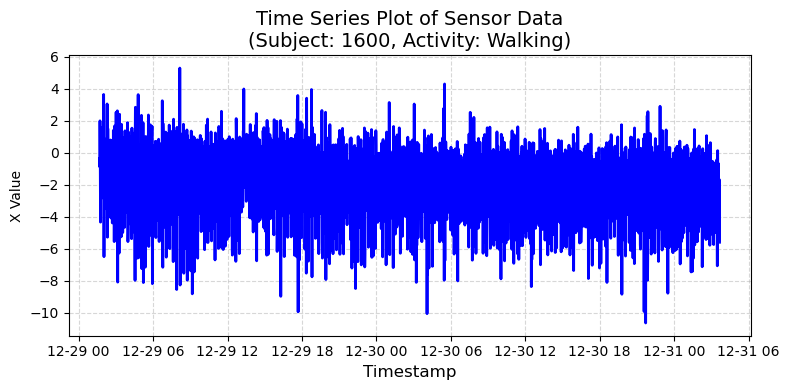

In [54]:
import matplotlib.pyplot as plt

# Choose a specific subject ID, activity, and sensor dimension for visualization
subject_id = 1600          # Choose one of the unique subject IDs
activity_code = 'Walking'  # Choose one of the unique activity codes
sensor_dimension = 'x'     # Replace with the sensor dimension you want to visualize (e.g., 'x', 'y', 'z')

# Filter data for the chosen subject ID, activity, and sensor dimension
filtered_data = phone_accel_df[(phone_accel_df['subject_id'] == subject_id) & 
                               (phone_accel_df['activity_code'] == activity_code)]

# Check if the filtered data is not empty
if not filtered_data.empty:
    # Plot the sensor readings over time for the chosen sensor dimension
    plt.figure(figsize=(8, 4))
    plt.plot(filtered_data['timestamp'], filtered_data[sensor_dimension], color='blue', linewidth=2)

    # Add labels and title
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel(sensor_dimension.capitalize() + ' Value', fontsize=10)
    plt.title('Time Series Plot of Sensor Data\n(Subject: {}, Activity: {})'.format(subject_id, activity_code), fontsize=14)

    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data found for the specified subject ID and activity code.")


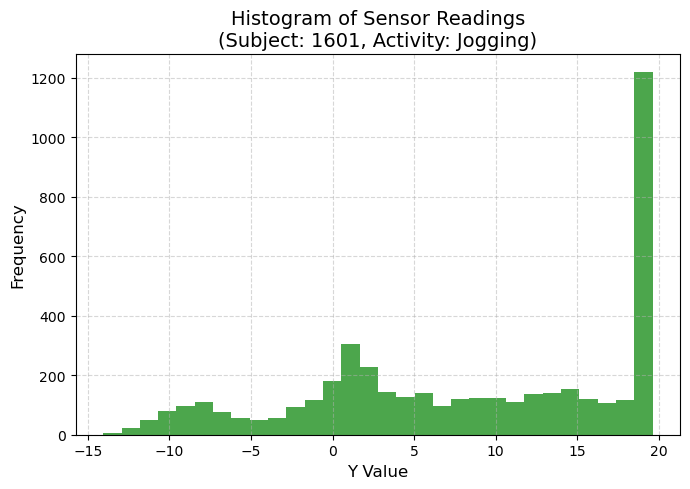

In [55]:
import matplotlib.pyplot as plt

# Choose a different specific subject ID, activity, and sensor dimension for visualization
subject_id = 1601          # Choose a different unique subject ID
activity_code = 'Jogging'  # Choose a different unique activity code
sensor_dimension = 'y'     # Replace with a different sensor dimension you want to visualize (e.g., 'x', 'y', 'z')

# Filter data for the chosen subject ID, activity, and sensor dimension
filtered_data = phone_accel_df[(phone_accel_df['subject_id'] == subject_id) & 
                               (phone_accel_df['activity_code'] == activity_code)]

# Check if the filtered data is not empty
if not filtered_data.empty:
    # Plot histogram of sensor readings for the chosen sensor dimension
    plt.figure(figsize=(7, 5))
    plt.hist(filtered_data[sensor_dimension], bins=30, color='green', alpha=0.7)

    # Add labels and title
    plt.xlabel(sensor_dimension.capitalize() + ' Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Sensor Readings\n(Subject: {}, Activity: {})'.format(subject_id, activity_code), fontsize=14)

    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data found for the specified subject ID and activity code.")


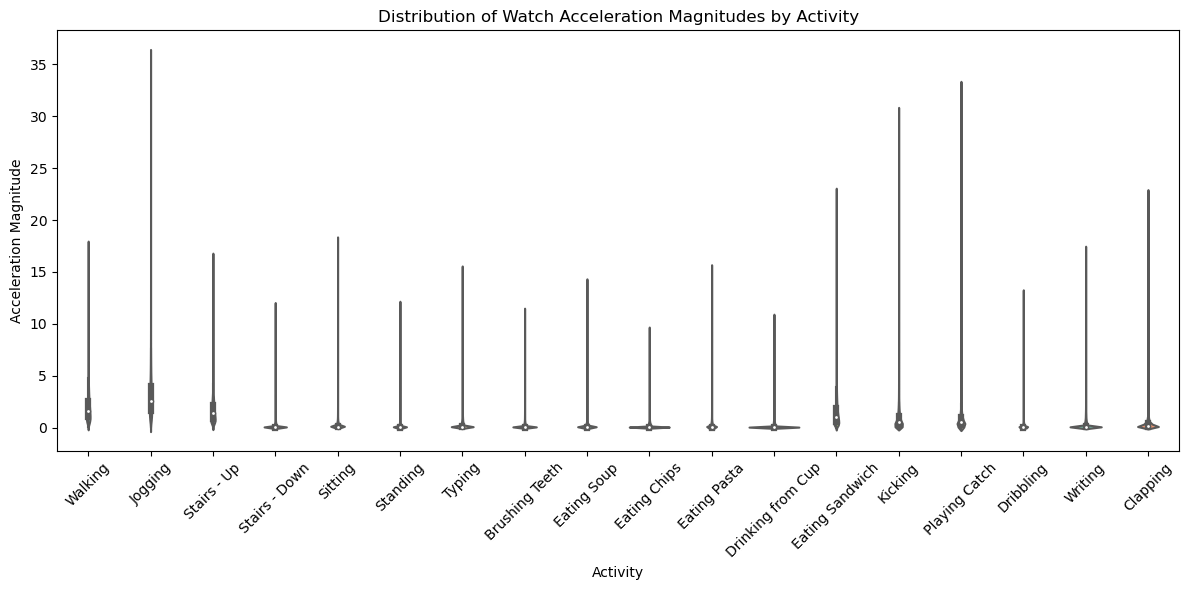

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a custom color palette
colors = sns.color_palette("Set2")

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=watch_accel_df, x='activity_code', y='accel_mag', palette=colors)

# Set labels and title
plt.xlabel('Activity')
plt.ylabel('Acceleration Magnitude')
plt.title('Distribution of Watch Acceleration Magnitudes by Activity')

# Remove the legend
plt.legend([],[], frameon=False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


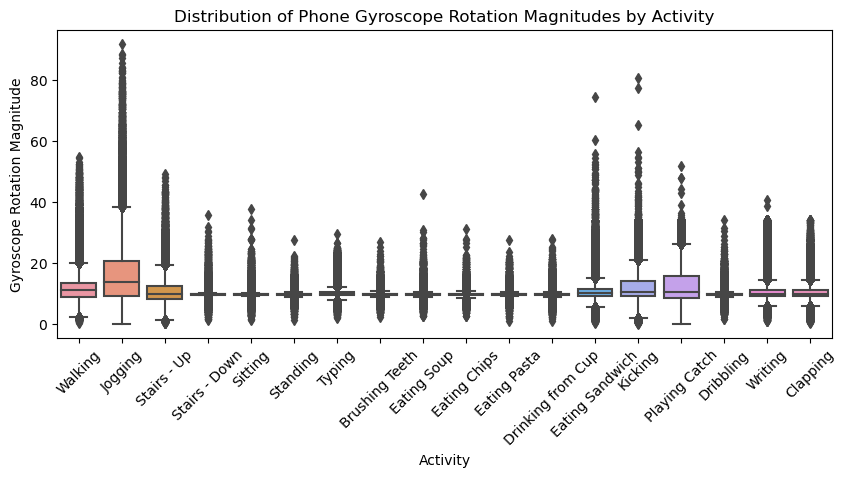

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate gyroscope magnitude for phone gyroscope data
phone_gyro_df['gyro_mag'] = np.sqrt(phone_gyro_df['x']**2 + phone_gyro_df['y']**2 + phone_gyro_df['z']**2)

# Create a box plot
plt.figure(figsize=(10, 4))
sns.boxplot(data=phone_gyro_df, x='activity_code', y='gyro_mag')
plt.xlabel('Activity')
plt.ylabel('Gyroscope Rotation Magnitude')
plt.title('Distribution of Phone Gyroscope Rotation Magnitudes by Activity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


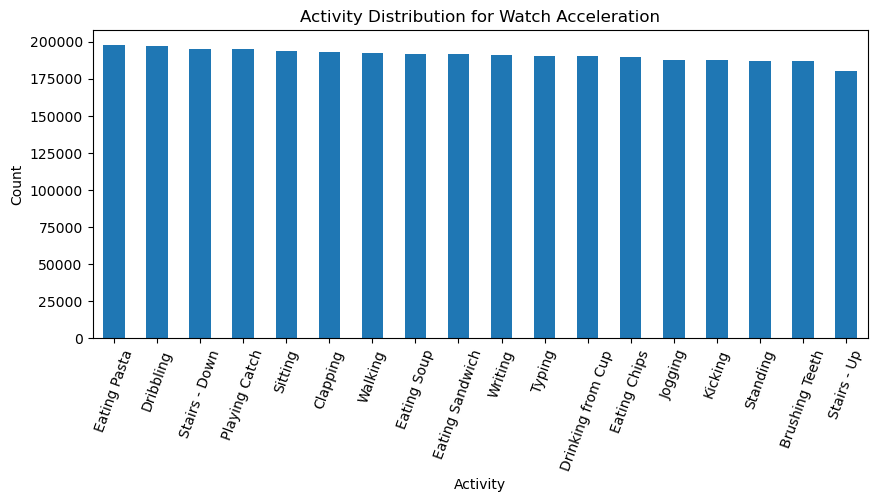

In [67]:
# Count the number of instances for each activity
activity_count = watch_gyro_df['activity_code'].value_counts()

# Plot a bar chart to visualize the activity distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
activity_count.plot(kind='bar')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Activity Distribution for Watch Acceleration')
plt.xticks(rotation=70)
plt.show()

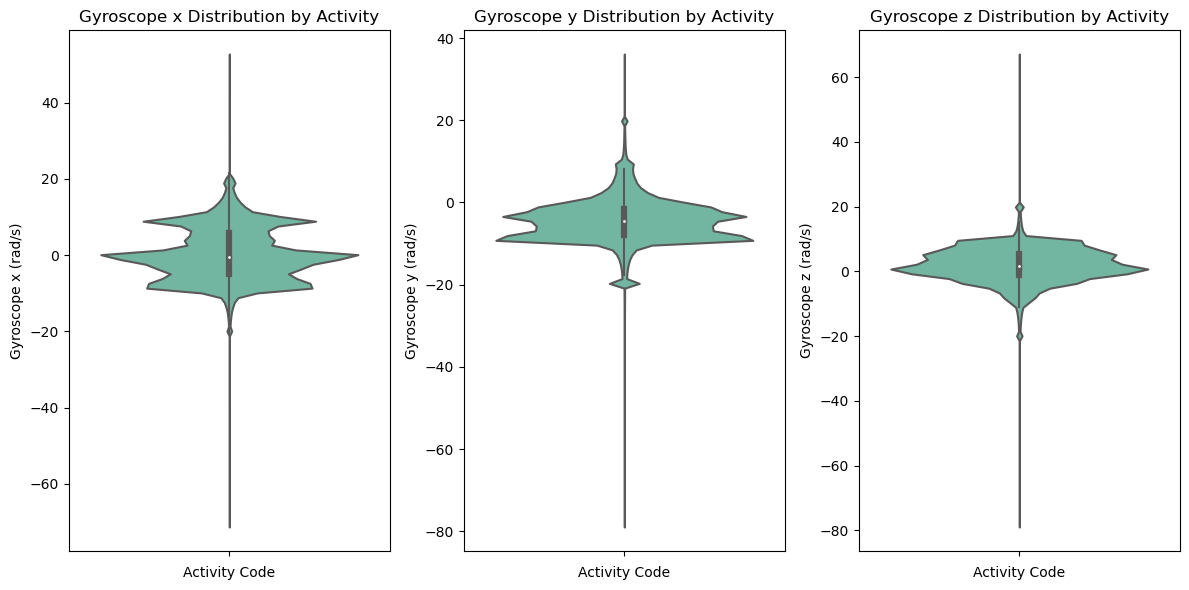

In [71]:
# Create violin plots for gyroscope values
plt.figure(figsize=(12, 6))

# Plot violin plots for each axis
plt.subplot(1, 3, 1)
sns.violinplot(data=phone_gyro_df, y='x', palette='Set2')
plt.xlabel('Activity Code')
plt.ylabel('Gyroscope x (rad/s)')
plt.title('Gyroscope x Distribution by Activity')

plt.subplot(1, 3, 2)
sns.violinplot(data=phone_gyro_df, y='y', palette='Set2')
plt.xlabel('Activity Code')
plt.ylabel('Gyroscope y (rad/s)')
plt.title('Gyroscope y Distribution by Activity')

plt.subplot(1, 3, 3)
sns.violinplot(data=phone_gyro_df, y='z', palette='Set2')
plt.xlabel('Activity Code')
plt.ylabel('Gyroscope z (rad/s)')
plt.title('Gyroscope z Distribution by Activity')

plt.tight_layout()
plt.show()


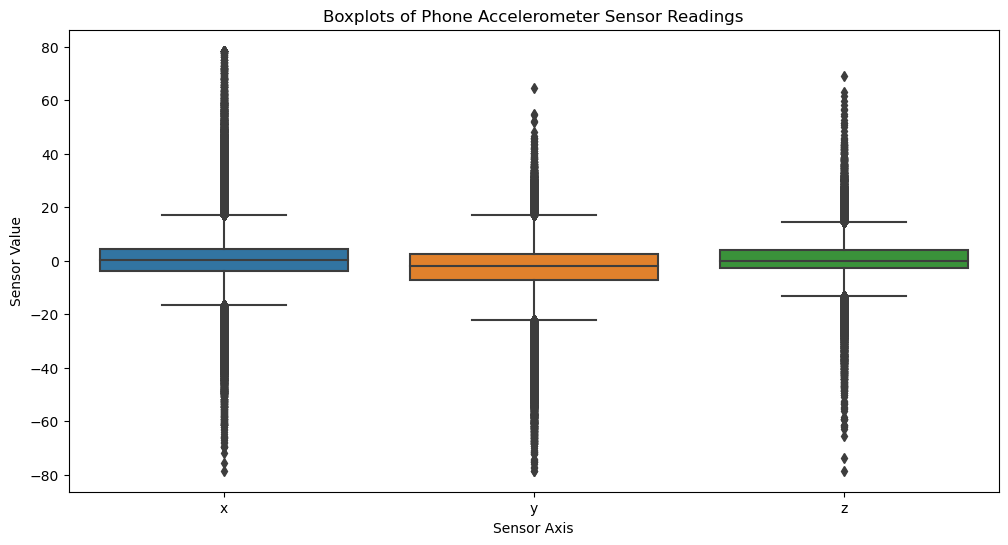

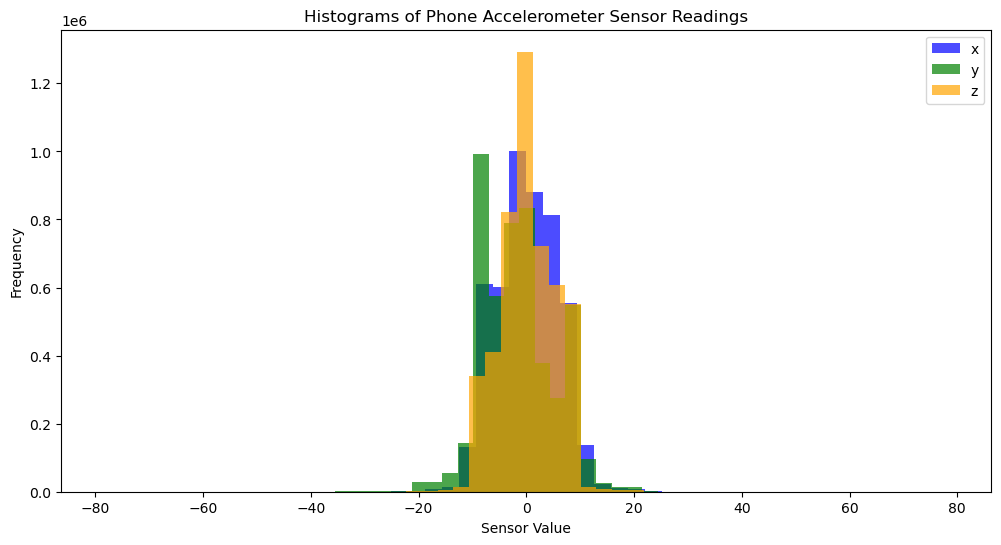

In [16]:

# Function to plot boxplots for each sensor axis (x, y, z)
def plot_boxplots(df, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[['x', 'y', 'z']])
    plt.title(title)
    plt.xlabel('Sensor Axis')
    plt.ylabel('Sensor Value')
    plt.show()

# Function to plot histograms for each sensor axis (x, y, z)
def plot_histograms(df, title):
    plt.figure(figsize=(12, 6))
    plt.hist(df['x'], bins=50, alpha=0.7, label='x', color='blue')
    plt.hist(df['y'], bins=50, alpha=0.7, label='y', color='green')
    plt.hist(df['z'], bins=50, alpha=0.7, label='z', color='orange')
    plt.title(title)
    plt.xlabel('Sensor Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot boxplots and histograms for phone accelerometer data
plot_boxplots(phone_accel_df, 'Boxplots of Phone Accelerometer Sensor Readings')
plot_histograms(phone_accel_df, 'Histograms of Phone Accelerometer Sensor Readings')


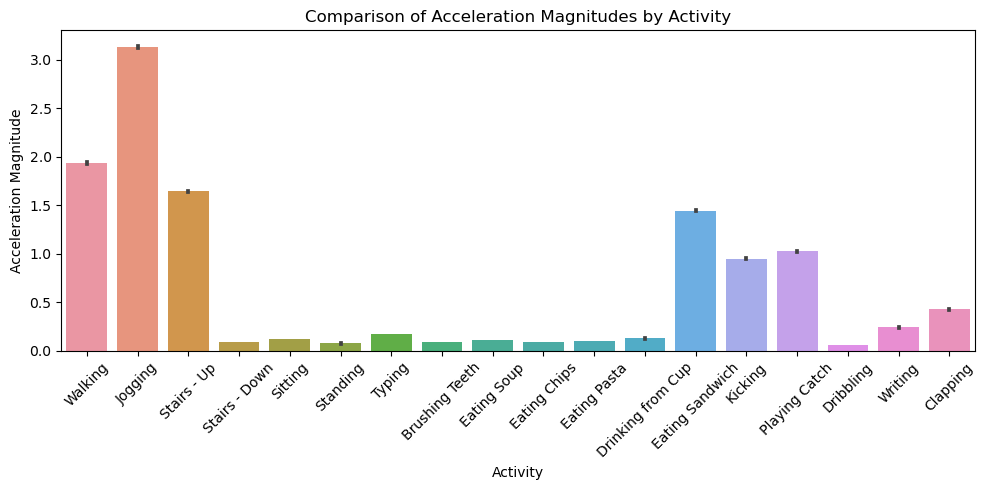

In [72]:

# Define the variables for the x-axis and y-axis
x_variable = 'activity_code'  # Assuming this is the variable for the x-axis
y_variable = 'accel_mag'      # Assuming this is the variable for the y-axis

# Create the bar plot
plt.figure(figsize=(10, 5))
sns.barplot(data=watch_accel_df, x=x_variable, y=y_variable)

# Add labels and title
plt.xlabel('Activity')
plt.ylabel('Acceleration Magnitude')
plt.title('Comparison of Acceleration Magnitudes by Activity')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


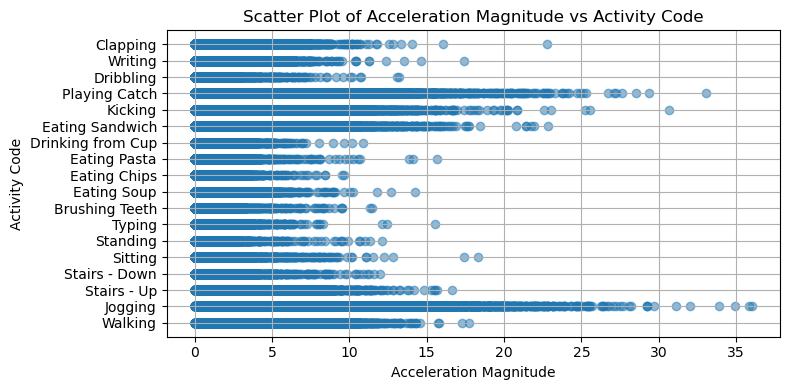

In [73]:
import matplotlib.pyplot as plt

# Define the variables for the x-axis and y-axis
x_variable = 'accel_mag'  # Assuming this is the variable name in your dataset
y_variable = 'activity_code'  # Assuming this is the variable name in your dataset

# Create the scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(watch_accel_df[x_variable], watch_accel_df[y_variable], alpha=0.5)

# Add labels and title
plt.xlabel('Acceleration Magnitude')
plt.ylabel('Activity Code')
plt.title('Scatter Plot of Acceleration Magnitude vs Activity Code')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


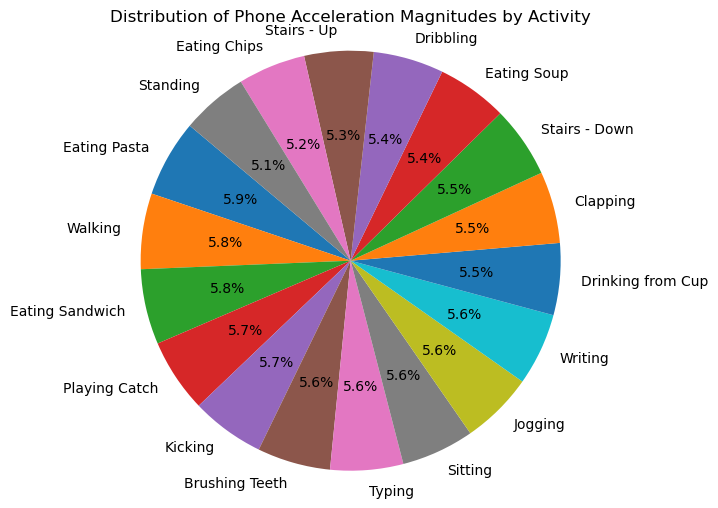

In [74]:
import matplotlib.pyplot as plt

# Calculate the total count of each activity
activity_counts = phone_accel_df['activity_code'].value_counts()

# Set up the pie chart
plt.figure(figsize=(8, 6))

# Plot the pie chart
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Phone Acceleration Magnitudes by Activity')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the plot
plt.show()
